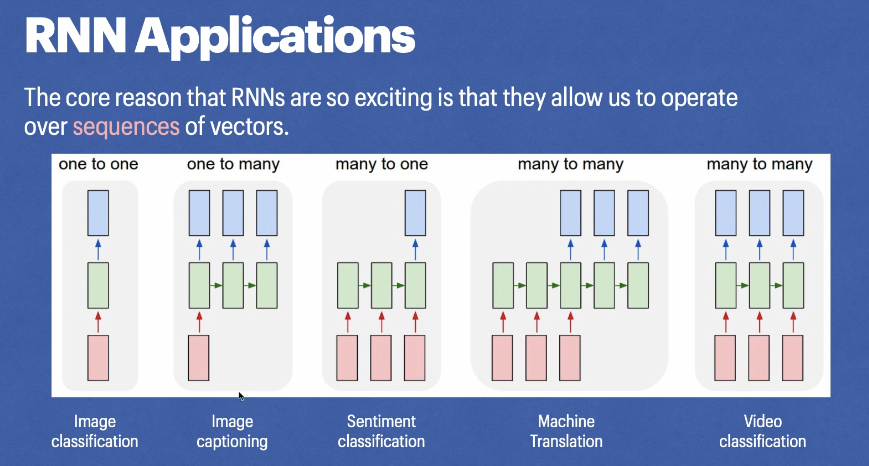
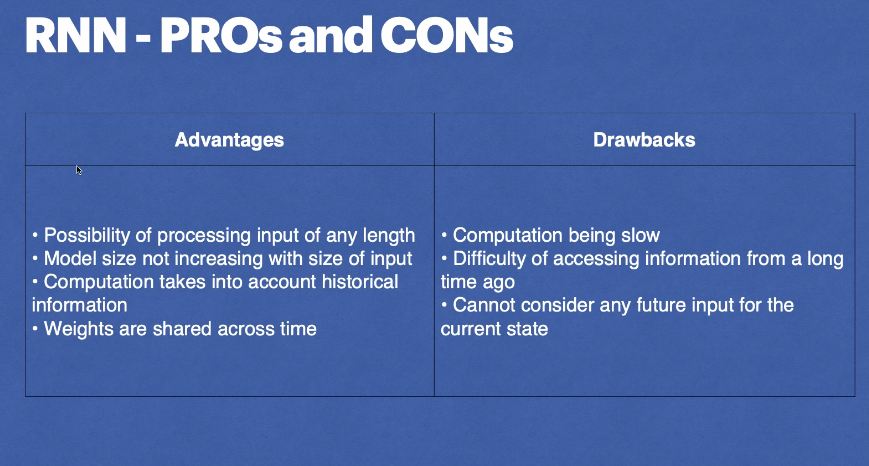
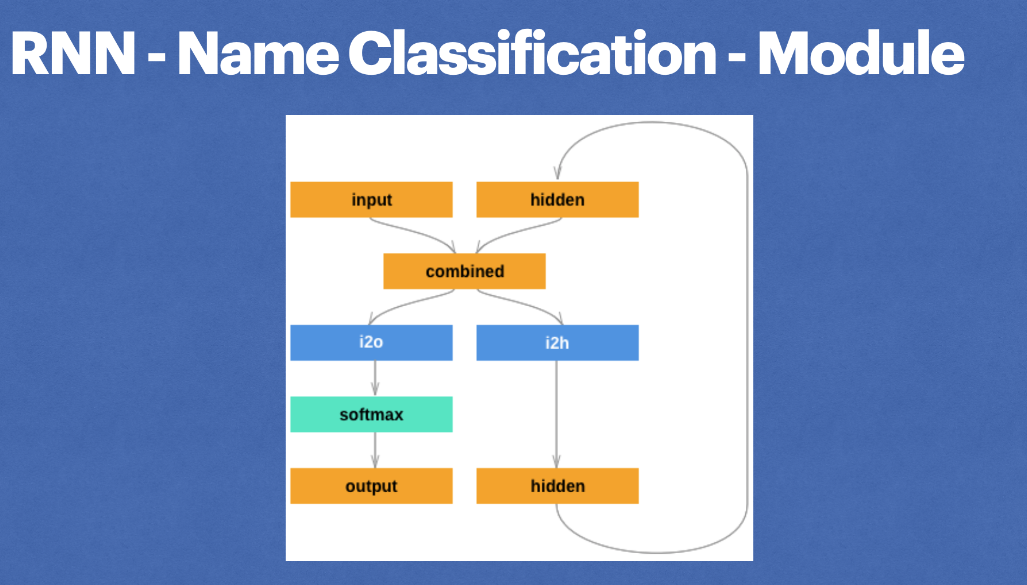

In [25]:
import io
import os
import unicodedata
import string
import glob

import torch
import random

import torch
import torch.nn as nn 
import matplotlib.pyplot as plt

# Data Processing

In [35]:
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

In [4]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

In [5]:
# Function to load data from text files, categorize them, and return the data with categories
def load_data():
    # Dictionary to store lines of names categorized by file name
    category_lines = {}
    # List to store all category names
    all_categories = []

    # Function to find files in the specified path
    def find_files(path):
        return glob.glob(path)  # Returns a list of file paths matching the specified pattern
    
    # Function to read lines from a file and convert each line to ASCII
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]  # Converts and returns ASCII lines
    
    # Iterate over each file in the directory 'data/names/' with a '.txt' extension
    for filename in find_files('data/names/*.txt'):
        # Extract the category name from the filename (without extension)
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)  # Add category to the list of categories

        # Read and store lines associated with the current category
        lines = read_lines(filename)
        #print(lines)
        category_lines[category] = lines  # Map category name to the list of names
    
    return category_lines, all_categories  # Return the dictionary of categories and the list of all categories

# Load data into the category_lines dictionary and all_categories list
category_lines, all_categories = load_data()

# Output the number of names in the 'Korean' category
len(category_lines['Korean'])


94

In [6]:
# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

In [7]:
torch.zeros(26)[0]

tensor(0.)

In [8]:
# Just for demonstration, turn a letter into a <1 x n_letters> Tensor

def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

letter_to_tensor('p')

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

In [9]:
# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors

def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor

line_to_tensor('line').size()

torch.Size([4, 1, 57])

In [26]:
def random_training_example(category_lines, all_categories):

    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1) # Random Number
        return a[random_idx] # Random thing from list
    

    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor


# Network

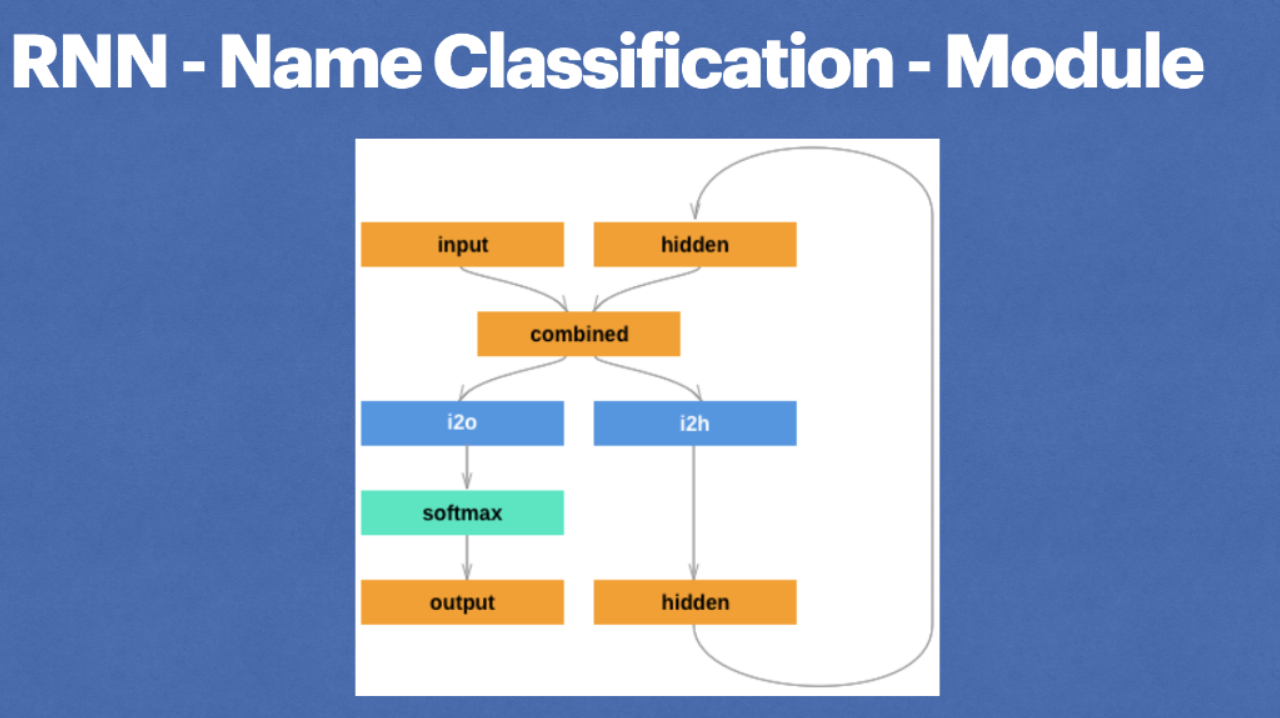

In [13]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size  # 1 x 128
        self.i2h = nn.Linear(input_size+hidden_size, hidden_size) # 1 x 128
        self.i2o = nn.Linear(input_size+hidden_size, output_size) # 1 x 18
        self.softmax = nn.Softmax(dim=1) # 1 x 18

    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        #print('Input,', input_tensor.size(),'.hidden,', hidden_tensor.size(), combined.size())
        hidden  = self.i2h(combined)
        #print(hidden.size())
        output = self.i2o(combined)
        #print(output.size())
        output1 = self.softmax(output)
        return output1, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [14]:
category_lines, all_categories = load_data()
n_categories = len(all_categories)
print(N_LETTERS)

57


In [28]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

print(category_from_output(output))

Chinese


# Train function

In [30]:
n_hidden = 128
criterion = nn.NLLLoss()
learning_rate = 0.05
optimizer = torch.optim.SGD(rnn.parameters(), lr = learning_rate)

def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()
    #print(line_tensor.size())

    for i in range(line_tensor.size()[0]): # [line size, 1, number of letters] -> [line size]
        output, hidden = rnn(line_tensor[i], hidden)  # [1, 18], [1, 128]
    
    loss = criterion(output, category_tensor)
    #print(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output,loss.item()

train(line_tensor, category_tensor)

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
        grad_fn=<SoftmaxBackward0>),
 0.0)

5000 50.0 0.0000 Ventura / Japanese WRONG (Portuguese)
10000 100.0 0.0000 Amelsvoort / Polish WRONG (Dutch)


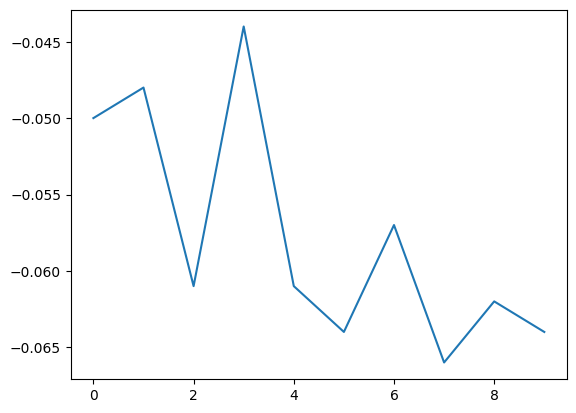

In [33]:
current_loss = 0
all_lossed = []
plot_steps, print_steps = 1000, 5000
n_iters = 10000

for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)

    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    if (i+1) % plot_steps == 0:
        all_lossed.append(current_loss / plot_steps)
        current_loss = 0

    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")


plt.figure()
plt.plot(all_lossed)
plt.show()

In [34]:
def predict(input_line):
    print(f'\n> {input_line}')
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)

        hidden = rnn.init_hidden()

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

            guess = category_from_output(output)
            print(guess)


sentence = input ('Input:')
predict(sentence)


> Acton
Korean
Vietnamese
Japanese
Polish
Japanese
